In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-05-31 16:15:33.623171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:15:33.884754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:15:33.886407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 16:15:38.077031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-31 16:15:45.122081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

### Set up bacco: cosmology and power spectrum parameters

In [2]:
idx_LH_str = '0663' # quijote LH idx to test
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

n_grid = 512
box_size = 1000.0

In [3]:
def get_cosmo(param_dict):
    a_scale = 1
    # omega_m = omega_cold + omega_neutrinos 
    # (omega_m = omega_cold if no neutrinos) 
    # Om_cdm = Om_cold - Om_baryon
    if 'omega_m' in param_dict:
        omega_cdm = param_dict['omega_m']-param_dict['omega_baryon']
    elif 'omega_cold' in param_dict:
        omega_cdm = param_dict['omega_cold']-param_dict['omega_baryon']
    else:
        raise ValueError("param_dict must include omega_m or omega_cold!")

    cosmopars = dict(
            omega_cdm=omega_cdm,
            omega_baryon=param_dict['omega_baryon'],
            hubble=param_dict['h'],
            ns=param_dict['n_s'],
            sigma8=param_dict['sigma_8'],
            tau=0.0561,
            A_s=None,
            neutrino_mass=0.,
            w0=-1,
            wa=0,
        )

    cosmo = bacco.Cosmology(**cosmopars)
    cosmo.set_expfactor(a_scale)
    return cosmo

In [4]:
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))
cosmo_Quijote = get_cosmo(param_dict)

2024-05-31 16:15:52,435 bacco.cosmo :    initialization took 0.000 secs


In [5]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


### Load linear & displacement fields for single Quijote sim

In [6]:
# Quijote LH test data

fn_sim = f'{dir_mocks}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
sim_disp = np.load(fn_sim)

fn_lin = f'{dir_mocks}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin = np.load(fn_lin)[0]

In [7]:
sim_disp.shape, dens_lin.shape

((3, 512, 512, 512), (512, 512, 512))

Add displacements to grid

In [8]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-05-31 16:16:08,267 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [9]:
grid.shape, sim_pos.shape

((512, 512, 512, 3), (134217728, 3))

Put displacements on mesh

In [10]:
sim_pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim_pos, vel=None, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(sim_pos_mesh.shape)

2024-05-31 16:16:16,087 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-31 16:16:16,087 bacco.statistics : starting deposit 1
2024-05-31 16:16:20,717 bacco.statistics :  mesh done in 4.63 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 512, 512, 512)


In [11]:
sim_pos_mesh_interlacing = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim_pos, vel=None, mass=None,
                 interlacing=True, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(sim_pos_mesh_interlacing.shape)

2024-05-31 16:16:22,670 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-31 16:16:22,671 bacco.statistics : starting deposit 1
2024-05-31 16:16:31,303 bacco.statistics :  mesh done in 8.63 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(2, 512, 512, 512)


-15.643541 14.582848
-15.643541 14.582848


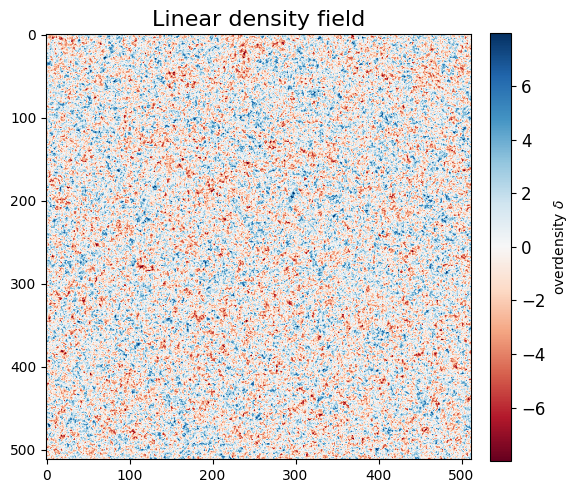

In [12]:
plotter.plot_overdensity_field(dens_lin, title=r'Linear density field',
                               #vmax=0.1
                               )

0.0 1313.9625
0.0 1313.9625


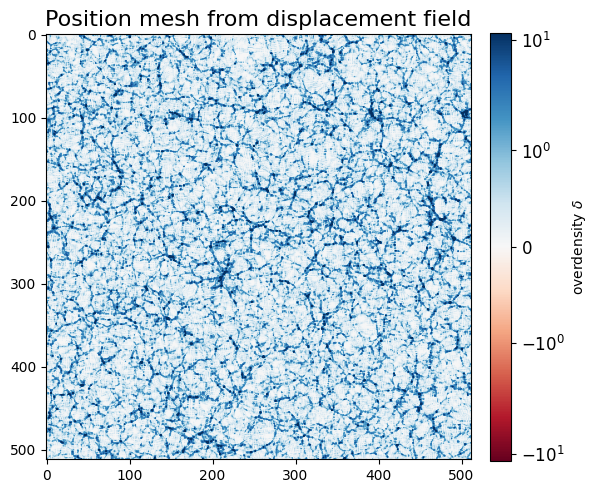

In [13]:
plotter.plot_overdensity_field(sim_pos_mesh[0], title=r'Position mesh from displacement field',
                               symlog=True, #vmax=0.1
                               )

### Compute power spectra of fields / particle positions

In [14]:
pk_obj_particles = bacco.statistics.compute_powerspectrum(
    pos=sim_pos,
    **args_power
)

2024-05-31 16:16:39,813 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-31 16:16:40,359 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.444 secs
2024-05-31 16:16:40,361 bacco.cosmo :    created Pk(z=0) tab from k 7.127584103727715e-05 to 100000.0 h/Mpc
2024-05-31 16:16:40,376 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.003 secs
2024-05-31 16:16:40,379 bacco.statistics :  setting the grid 512 False
2024-05-31 16:16:40,379 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-31 16:16:40,380 bacco.statistics : starting deposit 1
2024-05-31 16:16:44,742 bacco.statistics :  mesh done in 4.36 s
2024-05-31 16:16:44,751 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1


2024-05-31 16:16:46,313 bacco.statistics :  done compute.power
2024-05-31 16:16:46,315 bacco.statistics :  power done in 6.5 s


bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.530757 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.732603 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


In [15]:
args_power_nodeconv = args_power.copy()
args_power_nodeconv['deconvolve_grid'] = False
pk_obj_particles_nodeconv = bacco.statistics.compute_powerspectrum(
    pos=sim_pos,
    **args_power_nodeconv
)

2024-05-31 16:16:48,349 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-31 16:16:48,352 bacco.statistics :  setting the grid 512 False
2024-05-31 16:16:48,352 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-31 16:16:48,352 bacco.statistics : starting deposit 1
2024-05-31 16:16:52,698 bacco.statistics :  mesh done in 4.35 s
2024-05-31 16:16:52,700 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.571284 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.724587 sec


2024-05-31 16:16:54,470 bacco.statistics :  done compute.power
2024-05-31 16:16:54,472 bacco.statistics :  power done in 6.12 s


bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000156 secs
bacco.power : Deallocating arrays


In [16]:
args_power_interlacing = args_power.copy()
args_power_interlacing['interlacing'] = True
pk_obj_particles_interlacing = bacco.statistics.compute_powerspectrum(
    pos=sim_pos,
    **args_power_interlacing
)

2024-05-31 16:16:56,509 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-05-31 16:16:56,512 bacco.statistics :  setting the grid 512 True
2024-05-31 16:16:56,513 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=True
2024-05-31 16:16:56,513 bacco.statistics : starting deposit 1
2024-05-31 16:17:05,123 bacco.statistics :  mesh done in 8.61 s
2024-05-31 16:17:05,125 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.509554 sec
bacco.power : Counting modes


2024-05-31 16:17:08,042 bacco.statistics :  done compute.power
2024-05-31 16:17:08,045 bacco.statistics :  power done in 11.5 s


bacco.power : done counting modes in 0.811155 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000161 secs
bacco.power : Deallocating arrays


In [17]:
args_power_nocorrectgrid = args_power.copy()
args_power_nocorrectgrid['correct_grid'] = False
pk_obj_particles_nocorrectgrid = bacco.statistics.compute_powerspectrum(
    pos=sim_pos,
    **args_power_nocorrectgrid
)

2024-05-31 16:17:09,915 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-31 16:17:09,917 bacco.statistics :  setting the grid 512 False
2024-05-31 16:17:09,918 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-31 16:17:09,919 bacco.statistics : starting deposit 1
2024-05-31 16:17:14,132 bacco.statistics :  mesh done in 4.21 s
2024-05-31 16:17:14,134 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


2024-05-31 16:17:15,877 bacco.statistics :  done compute.power
2024-05-31 16:17:15,879 bacco.statistics :  power done in 5.96 s


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.542867 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.757949 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000331 secs
bacco.power : Deallocating arrays


In [18]:
kk = pk_obj_particles['k']

In [19]:

pk_obj_mesh = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh,
                    grid2=sim_pos_mesh,
                    **args_power_grid)

2024-05-31 16:17:19,472 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.062548 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.770675 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-05-31 16:17:24,122 bacco.statistics :  ...done in 4.65 s


In [20]:
args_power_grid_interlacing = args_power_grid.copy()
args_power_grid_interlacing['interlacing'] = True

pk_obj_mesh_interlacing = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh_interlacing,
                    grid2=sim_pos_mesh_interlacing,
                    **args_power_grid_interlacing)

2024-05-31 16:17:25,898 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 1; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.147351 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.908390 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000156 secs
bacco.power : Deallocating arrays


2024-05-31 16:17:34,229 bacco.statistics :  ...done in 8.33 s


In [21]:
pk_obj_particles['pk'], pk_obj_mesh['pk']

(array([30440.30747333, 20162.01865658, 24147.49055523, 12576.9136748 ,
        18149.81866524, 22487.40278362, 18143.79962248, 17785.43739116,
        15360.37089936, 13792.80734002, 11346.66466237, 10287.34212102,
         9217.06259779,  7165.85720918,  5685.19026643,  4663.33012162,
         3988.76092933,  3064.19407727,  2536.28552407,  2058.45580755,
         1699.2665119 ,  1385.04521069,  1156.68988857,   978.88710404,
          828.95667709,   709.38520071,   609.07071451,   524.73249668,
          452.28530413,     0.        ]),
 array([30439.00119116, 20165.63347166, 24150.3115815 , 12576.65421346,
        18148.96121923, 22498.29633489, 18142.67514011, 17780.80196587,
        15359.33850656, 13791.19930836, 11347.12437988, 10288.89435474,
         9222.38397323,  7167.42355984,  5690.20239558,  4667.49445126,
         3995.84118923,  3068.50311669,  2531.41624854,  2058.09301355,
         1701.60947414,  1385.81813781,  1159.94139861,   979.13313469,
          829.21812892

In [22]:
pk_obj_particles_interlacing['pk'], pk_obj_mesh_interlacing['pk']

(array([30440.31017151, 20162.00764484, 24147.49813694, 12576.92021349,
        18149.83098693, 22487.3932973 , 18143.80943028, 17785.4170488 ,
        15360.36636527, 13792.77911732, 11346.66194672, 10287.32293535,
         9217.04467152,  7165.87986718,  5685.18244372,  4663.31395324,
         3988.75581841,  3064.17960832,  2536.25220738,  2058.40002011,
         1699.24911478,  1384.98870502,  1156.61271298,   978.77320533,
          828.79370636,   709.10437381,   608.51008583,   523.60692934,
          449.96332149,     0.        ]),
 array([30439.00388921, 20165.62245794, 24150.31916423, 12576.66075345,
        18148.97353675, 22498.28684492, 18142.68494859, 17780.78163324,
        15359.33396942, 13791.17109001, 11347.1216637 , 10288.87515198,
         9222.36605734,  7167.4462331 ,  5690.19455822,  4667.47824984,
         3995.83607283,  3068.48863286,  2531.38295442,  2058.0372524 ,
         1701.59200472,  1385.76162211,  1159.86397095,   979.01921166,
          829.05511231

In [23]:
assert np.allclose(pk_obj_particles['pk'], pk_obj_mesh['pk'], rtol=0.01)

### Load in emulators, compute emu P(k)'s

In [24]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'omega_baryon': 'omega_baryon',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names if param_name in param_names_2_emu_param_names]

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
for param_name in param_names:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

### Quijote via globus

Pre-computed P(k):

In [27]:
dir_quijote_pks = f'/dipc/kstoreyf/Quijote_simulations/Pk/matter/latin_hypercube/{int(idx_LH_str)}'
fn_quijote_pk = f'{dir_quijote_pks}/Pk_m_z=0.txt'
print(fn_quijote_pk)
k_quijote, pk_quijote = np.loadtxt(fn_quijote_pk, unpack=True)

/dipc/kstoreyf/Quijote_simulations/Pk/matter/latin_hypercube/663/Pk_m_z=0.txt


In [28]:
# compute sigma_G for pk_quijote
# copied from approx_number_k_modes and approx_pk_gaussian_error in bacco.statistics
# doing here manually because k_quijote has LINEAR BINNING, and our config has log!!! 
kf = 2.0 * np.pi / box_size
N_kmodes = 4.0 * np.pi * (k_quijote / kf)**2
err_quijote = np.sqrt(2.0 / N_kmodes) * pk_quijote

Particle snapshot:

In [29]:
import readgadget
dir_quijote_snaps = f'/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{int(idx_LH_str)}'
snapshot = f'{dir_quijote_snaps}/snapdir_004/snap_004' # 004 = z0
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)
#header   = readgadget.header(snapshot)
#print(header)
pos_snap = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel_snap = readgadget.read_block(snapshot, "VEL ", ptype)

In [30]:
pk_obj_snap = bacco.statistics.compute_powerspectrum(
    pos=pos_snap,
    **args_power
)

2024-05-31 16:18:01,366 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-31 16:18:01,368 bacco.statistics :  setting the grid 512 False
2024-05-31 16:18:01,369 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-31 16:18:01,371 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)


2024-05-31 16:18:05,363 bacco.statistics :  mesh done in 3.99 s
2024-05-31 16:18:05,365 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : Using mass = 1.000000


2024-05-31 16:18:07,020 bacco.statistics :  done compute.power
2024-05-31 16:18:07,023 bacco.statistics :  power done in 5.66 s


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.543309 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.724003 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays


### Plot

/tmp/ipykernel_401812/3068817174.py:52: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_401812/3068817174.py:53: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


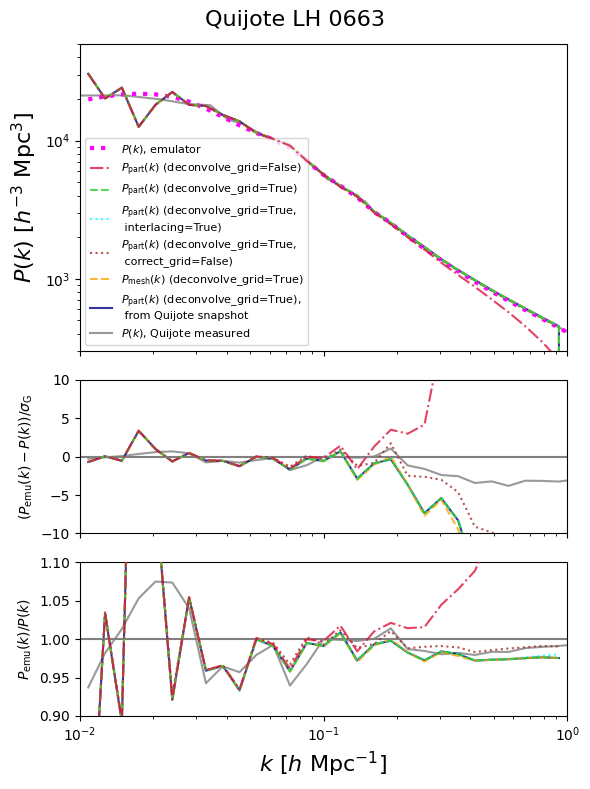

In [32]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
          #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
          r'$P_\text{part}(k)$ (deconvolve_grid=True)',
          r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
          r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
          r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
          r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
          ]
colors = ['crimson', 'limegreen', 'cyan', 'brown', 'orange', 'darkblue',]
lss = ['-.', '--', ':', ':', '--', '-']
pk_objs = [pk_obj_particles_nodeconv,
           pk_obj_particles,
           pk_obj_particles_interlacing,
           pk_obj_particles_nocorrectgrid,
           pk_obj_mesh, 
           #pk_obj_particles_deconv_Mpcperh, 
           #pk_obj_pos_mesh_deconv, 
           pk_obj_snap,
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

ks.append(k_quijote)
pks.append(pk_quijote)
errs.append(err_quijote)
#errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
labels.append(r'$P(k)$, Quijote measured')
colors.append('grey')
lss.append('-')
zorders.append(0)

plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

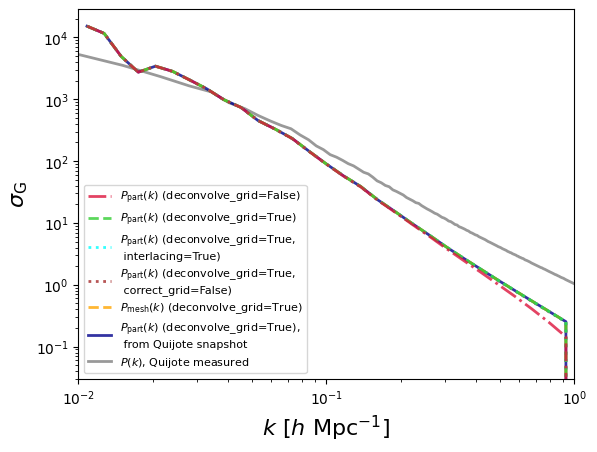

In [33]:
plt.figure()
ax = plt.gca()

for i in range(len(pks)):
    ax.plot(ks[i], errs[i], ls=lss[i], lw=2, color=colors[i], alpha=0.8, zorder=zorders[i],
            label=labels[i])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$\sigma_\text{G}$', fontsize=16)
ax.set_xlim(1e-2, 1)

ax.legend(fontsize=8, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

/tmp/ipykernel_401812/1833270708.py:22: RuntimeWarning: invalid value encountered in divide
  ax1.plot(ks[i], errs[i]/err_approx, ls=lss[i],color=colors[i], alpha=alpha, zorder=zorders[i],


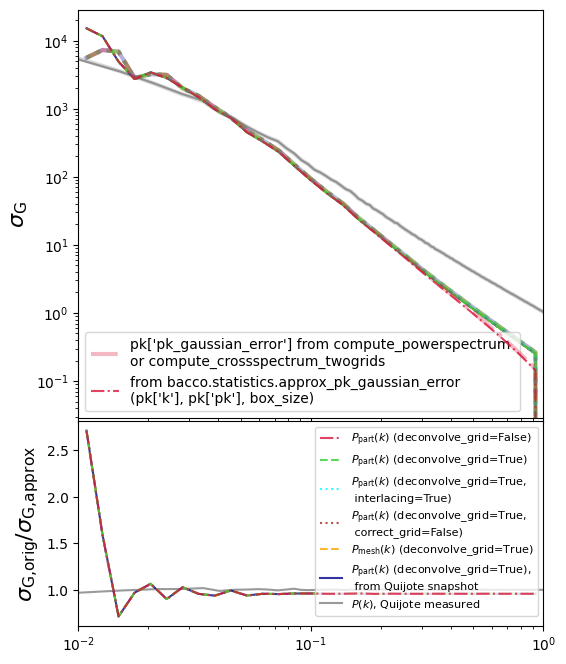

In [34]:
#plt.figure()
#ax = plt.gca()

nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr

for i in range(len(pks)):
#for i in [3,6]:
    err_approx = bacco.statistics.approx_pk_gaussian_error(ks[i], pks[i], box_size)
    if i==0:
        label_orig = "pk['pk_gaussian_error'] from compute_powerspectrum \nor compute_crossspectrum_twogrids" 
        label_approx = "from bacco.statistics.approx_pk_gaussian_error\n(pk['k'], pk['pk'], box_size)"
    else:
        label_orig, label_approx = None, None
    ax.plot(ks[i], err_approx, ls=lss[i], lw=3, color=colors[i], alpha=0.3, zorder=zorders[i],
            label=label_orig)
    ax.plot(ks[i], errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i],
            label=label_approx)

    ax1.plot(ks[i], errs[i]/err_approx, ls=lss[i],color=colors[i], alpha=alpha, zorder=zorders[i],
             label=labels[i]
            )

ax.legend()
ax1.legend(fontsize=8, loc='upper right')

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$\sigma_\text{G}$', fontsize=16)
ax1.set_ylabel(r'$\sigma_\text{G,orig}/\sigma_\text{G,approx}$', fontsize=16)
ax.set_xlim(1e-2, 1)

ax.set_xscale('log')
ax.set_yscale('log')